Imports

In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.discrete.discrete_model import Probit
import scipy.stats as stats

# Data Prep

1) Load the dataset for the S&P 500
2) Format the date to datetime format
3) Sort values by date from oldest to newest
4) Repeat 1-3 for Nvidia
5) Merge dataframes on the Date column using the S&P 500 as the leading dataframe
6) create log returns
7) Drop missing observations (NaN)

In [32]:
# 1  einlesen von Daten in der Rohform
df = pd.read_excel('SPX.xlsx')
# 2 Date to time im Format
df["Date"] = pd.to_datetime(df['Date'], format='%Y%m%d')
#3 Sort Values after the Date
df = df.sort_values("Date")
#4 Same vor NVDA
dfNV = pd.read_excel("NVDA.xlsx")
dfNV["Date"] = pd.to_datetime(dfNV["Date"],format='%Y%m%d')
dfNV = dfNV.sort_values("Date")
#5 Merging Rules : df wird erhalten und die dfNV kommt dazu also SP hier leading
df = df.merge(dfNV, how="left", on="Date")
#6 Create log returns
df["returnsSPX"] = np.log(df["SPX"]).diff()
df["returnsNV"] = np.log(df["NVDA"]).diff()
#7 die fehlenden werden rausgeworfen
df = df.dropna().reset_index(drop=True)
# zum auslesen
df.describe()



,Date,SPX,NVDA,returnsSPX,returnsNV
count,676,676.000000,676.000000,676.000000,676.000000
mean,2024-05-09 09:43:40.118343168,5151.449009,90.086915,0.000809,0.003705
min,2023-01-04 00:00:00,3808.100000,14.265000,-0.061609,-0.185946
25%,2023-09-06 18:00:00,4414.327500,44.676000,-0.003501,-0.013741
50%,2024-05-08 12:00:00,5216.135000,92.309500,0.000944,0.003924
75%,2025-01-10 18:00:00,5837.532500,131.175000,0.005861,0.021791
max,2025-09-15 00:00:00,6609.400000,183.160000,0.090895,0.218088
std,NaN,765.608040,48.060502,0.009663,0.032049


# Meanvariance

1) Store means in new variables
2) Store variance in new variables
3) Store standard deviation in new variables
4) Store skewness in new variables
5) Store kurtosis in new variables

In [33]:
#1
spx_mean = df['returnsSPX'].mean()
#2
spx_variance = df['returnsSPX'].var()
#3
spx_std = df['returnsSPX'].std()
#4
spx_skewness = df['returnsSPX'].skew()
#5
spx_kurtosis = df['returnsSPX'].kurtosis()

nvda_mean = df['returnsNV'].mean()
nvda_variance = df['returnsNV'].var()
nvda_std = df['returnsNV'].std()
nvda_skewness = df['returnsNV'].skew()
nvda_kurtosis = df['returnsNV'].kurtosis()


SPX

In [21]:
print(spx_mean, spx_variance, spx_std, spx_skewness, spx_kurtosis)

0.0008094072082658398 9.338212214893735e-05 0.009663442561992974 0.3794123464805598 14.48577578706454


NVDA

In [22]:
print(nvda_mean,nvda_variance,nvda_std, nvda_skewness,nvda_kurtosis)

0.0037048484256013603 0.0010271198758041934 0.03204871098506449 0.4004123017185249 6.564691398616426


# OLS Regression

1) Regress log returns of NVDA on log returns of SPX
2) Extract and analyze the results (summary function)

In [34]:
# 1 retrun
ols = sm.regression.linear_model.OLS(df["returnsNV"], sm.add_constant(df['returnsSPX'])).fit()

ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              returnsNV   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     486.7
Date:                Wed, 22 Oct 2025   Prob (F-statistic):           1.33e-81
Time:                        17:24:52   Log-Likelihood:                 1550.8
No. Observations:                 676   AIC:                            -3098.
Df Residuals:                     674   BIC:                            -3089.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.085      0.037       0.000       0.004
returnsSPX     2.1476      0.097     22.061      0.000       1.956       2.339
==============================================================================
Omnibus:                      189.484   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2841.278
Skew:                           0.817   Prob(JB):                         0.00
Kurtosis:                      12.910   Cond. No.                         104.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Jupiter 2 tutorial


reanming Data

In [35]:
# Altername neuer Name
df = df.rename(columns={'returnsNV':'NVDA_returns', 'returnsSPX':'SPX_retruns'})
df.head()

,Date,SPX,NVDA,SPX_retruns,NVDA_returns
0,2023-01-04,3852.97,14.749,0.007511,0.029867
1,2023-01-05,3808.10,14.265,-0.011714,-0.033366
2,2023-01-06,3895.08,14.859,0.022584,0.040797
3,2023-01-09,3892.09,15.628,-0.000768,0.050458
4,2023-01-10,3919.25,15.909,0.006954,0.017821


3) Load the Fama-French 5-factor (FF5) time-series data
4) Format the dates to datetime format
5) Merge the SPX/NVDA data and the FF5 data using the SPX/NVDA dataframe as the leading dataframe
6) Compute excess returns for NVDA by subtracting the risk-free rate (column "RF" in FF5) from simple NVDA returns

In [36]:
# 3 wie oben
FF5 = pd.read_excel('F-F_Research_Data_5_Factors_2x3_daily.xlsx')
FF5['Date'] = pd.to_datetime(FF5['Date'], format='%Y%m%d')
# Wir wandeln hier die Porzent werte die  FF ausgibt dafür wandeln wir jeden weert in ein Dezimal wert um und dann passen wir ihn an also "24%" -> 0,24
factor_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
FF5[factor_cols] = FF5[factor_cols].apply(lambda col: pd.to_numeric(col, errors='coerce')) / 100

#5 Hier wieder mergen wo  df das haupt dataframe ist
df = df.merge(FF5, how='left', on='Date')

# 6
df = df.dropna(subset=['NVDA_returns'] + factor_cols).reset_index(drop=True)
df['excess_ret_asset'] = df['NVDA_returns'] - df['RF']

df.head()



,Date,SPX,NVDA,SPX_retruns,NVDA_returns,Mkt-RF,SMB,HML,RMW,CMA,RF,excess_ret_asset
0,2023-01-04,3852.97,14.749,0.007511,0.029867,0.0081,0.0056,0.0005,-0.0069,0.0000,0.0002,0.029667
1,2023-01-05,3808.10,14.265,-0.011714,-0.033366,-0.0114,0.0017,0.0120,0.0081,0.0090,0.0002,-0.033566
2,2023-01-06,3895.08,14.859,0.022584,0.040797,0.0221,-0.0001,0.0003,0.0082,0.0018,0.0002,0.040597
3,2023-01-09,3892.09,15.628,-0.000768,0.050458,0.0003,0.0033,-0.0123,-0.0065,-0.0116,0.0002,0.050258
4,2023-01-10,3919.25,15.909,0.006954,0.017821,0.0079,0.0087,-0.0056,-0.0040,-0.0050,0.0002,0.017621


# Multivariant regression

1) Regress NVDA excess returns on a constant and all 5 Fama-French factors ("Mkt-RF", "SMB", "HML", "RMW", "CMA")

In [37]:
Y = df['excess_ret_asset']
X = df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       excess_ret_asset   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     149.3
Date:                Wed, 22 Oct 2025   Prob (F-statistic):          7.34e-105
Time:                        17:39:11   Log-Likelihood:                 1543.0
No. Observations:                 645   AIC:                            -3074.
Df Residuals:                     639   BIC:                            -3047.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.115      0.035       0.000       0.004
Mkt-RF         2.0007      0.096     20.877      0.000       1.812       2.189
SMB           -0.5027      0.150     -3.356      0.001      -0.797      -0.209
HML           -1.3627      0.146     -9.351      0.000      -1.649      -1.077
RMW            0.4705      0.201      2.338      0.020       0.075       0.866
CMA            0.3649      0.190      1.924      0.055      -0.008       0.737
==============================================================================
Omnibus:                      186.790   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2212.689
Skew:                           0.930   Prob(JB):                         0.00
Kurtosis:                      11.881   Cond. No.                         269.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Deutung der Tabelle:

Also schaue in der coffezienze tabelle, was kleiner und das will ich mir anschauen alsi umsokleiner P>T dings umso wischtiger ist das. Z.B. CMA ist zu hoch deswegen sit das scheiß egal weil es 0.102 ist das heiußt das einfach zu hoch

Dann interepretation was mache ich wenn als bsp mein Market RF wenn das um 1 hoch geht dann geht NVDA um 0.0203 hoch also um den wert der da angegeben wird bei coef. bzw wenn iche s weiter eherhöe dann gehts weiter hoch.

Prp: durch slides gehen und checken wo die alle zu finden sind in der tabelle so die connections machen. Glaube da wird dann alles abgefragt also z.B. Skew was das was mcht das etc was R2 und so also die tabelle verstehen und wissen wo alles steht





In [38]:
factor_loadings = pd.DataFrame({
    'coef': model.params,
    't_stat': model.tvalues,
    'p_value': model.pvalues
})
factor_loadings


,coef,t_stat,p_value
const,0.001865,2.114923,3.482301e-02
Mkt-RF,2.000664,20.876824,3.443360e-74
SMB,-0.502730,-3.356430,8.363649e-04
HML,-1.362656,-9.351024,1.438244e-19
RMW,0.470550,2.337570,1.971735e-02
CMA,0.364945,1.924028,5.479492e-02


# FED Probit model

1) Load the dataset containing the difference between the 3-month and 10-year Treasury yield (t10y3m)
2) Ensure the dates are in datetime format and create a new column that contains the first date of the month to use it as a month indicator
3) Group data by that month indicator taking the monthly mean of the yield spread

In [39]:
#1
t10y3m = pd.read_excel("T10Y3M.xlsx")
t10y3m["observation_date"] = pd.to_datetime(t10y3m["observation_date"])
t10y3m["month"] = t10y3m["observation_date"].dt.to_period("M").dt.to_timestamp()
t10y3m = t10y3m.groupby("month",as_index=False)["T10Y3M"].mean()
t10y3m

,month,T10Y3M
0,1982-01-01,1.676000
1,1982-02-01,0.146111
2,1982-03-01,0.546522
3,1982-04-01,0.527143
4,1982-05-01,0.908500
...,...,...
521,2025-06-01,-0.037500
522,2025-07-01,-0.020455
523,2025-08-01,-0.040000
524,2025-09-01,0.054762


4) Load the dataset with monthly recession indicators and ensure the date column is in datetime format

In [40]:
usrce = pd.read_excel('USREC.xlsx')
usrce['observation_date'] = pd.to_datetime(usrce['observation_date'])
usrce['month'] = usrce['observation_date'].dt.to_period('M').dt.to_timestamp()
usrce = usrce.groupby('month', as_index=False)['USREC'].mean()
usrce.head()


,month,USREC
0,1900-02-01,1.0
1,1900-03-01,1.0
2,1900-04-01,1.0
3,1900-05-01,1.0
4,1900-06-01,1.0


5) Merge the two dataframes using on the month indicator the yield spread as the leading dataframe
6) Create a new column that gives the 12 months ahead recession indicator using the .shift() method
7) Drop NaN observations

In [41]:
fed_rec = t10y3m.merge(usrce, how='left', on='month')
fed_rec['USREC_12m'] = fed_rec['USREC'].shift(-12)
fed_rec = fed_rec.dropna(subset=['USREC_12m']).reset_index(drop=True)
fed_rec.head()


,month,T10Y3M,USREC,USREC_12m
0,1982-01-01,1.676000,1.0,0.0
1,1982-02-01,0.146111,1.0,0.0
2,1982-03-01,0.546522,1.0,0.0
3,1982-04-01,0.527143,1.0,0.0
4,1982-05-01,0.908500,1.0,0.0


8) Estimate a probit model with an intercept, the yield spread as an independent variable and 12 month ahead recession indicator as the dependent variable using data until December 2009

In [42]:
est_sample = fed_rec[fed_rec['month'] <= '2009-12-31']
X_est = sm.add_constant(est_sample['T10Y3M'])
y_est = est_sample['USREC_12m']

probit_model = Probit(y_est, X_est).fit(disp=False)
probit_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              USREC_12m   No. Observations:                  336
Model:                         Probit   Df Residuals:                      334
Method:                           MLE   Df Model:                            1
Date:                Wed, 22 Oct 2025   Pseudo R-squ.:                  0.2598
Time:                        18:35:08   Log-Likelihood:                -81.503
converged:                       True   LL-Null:                       -110.10
Covariance Type:            nonrobust   LLR p-value:                 3.933e-14
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4006      0.148     -2.707      0.007      -0.691      -0.111
T10Y3M        -0.7572      0.125     -6.058      0.000      -1.002      -0.512
==============================================================================
"""

9) Based on this model, predict the probability of a recession for each month in the entire dataset and plot that probability over time

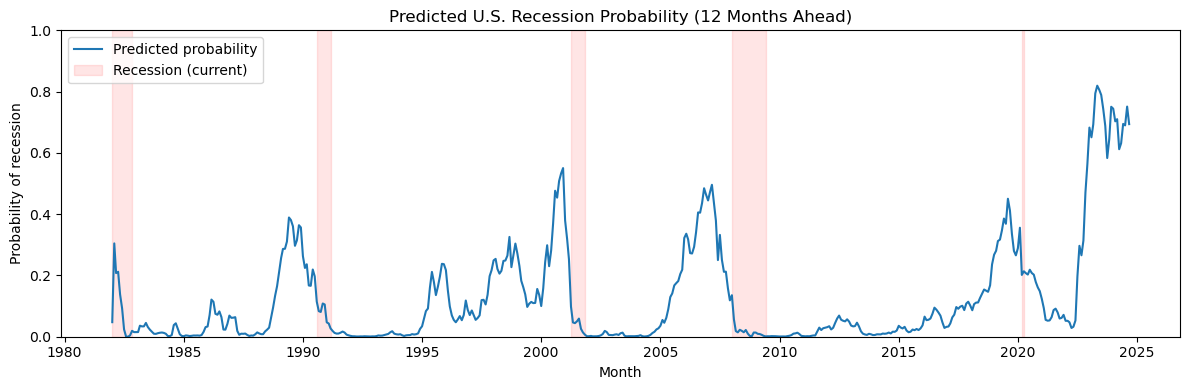

In [43]:
X_all = sm.add_constant(fed_rec['T10Y3M'])
fed_rec['recession_prob'] = probit_model.predict(X_all)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(fed_rec['month'], fed_rec['recession_prob'], label='Predicted probability')
ax.fill_between(
    fed_rec['month'],
    0,
    1,
    where=fed_rec['USREC'] > 0.5,
    color='red',
    alpha=0.1,
    label='Recession (current)'
)
ax.set_xlabel('Month')
ax.set_ylabel('Probability of recession')
ax.set_title('Predicted U.S. Recession Probability (12 Months Ahead)')
ax.set_ylim(0, 1)
ax.legend(loc='upper left')
fig.tight_layout()
